In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA

import umap
import Modules.rnaseqTools as rnaT
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from Modules import generate_figures

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['ytick.major.width'] = .5

In [2]:
def read_dataset(dataset):
    kwargs = {'sep':'\t', 'header':0, 'index_col':0}
    fname = 'Datasets/%s-tpm.tsv' % dataset
    df = pd.read_csv(fname, **kwargs)
    
    fname = 'Datasets/%s-labels.tsv' % dataset
    df_label = pd.read_csv(fname, **kwargs)
    
    arrays = [df_label.index, df_label.CellType]
    names = ['Cell', 'CellType']
    df.columns = pd.MultiIndex.from_arrays(arrays, names=names)
    
    return df.T

def get_lin_data():
    df_lin = read_dataset('Lab_Pvalb')
    fname = 'Datasets/Lab_Pvalb-transcriptional_labels.tsv'
    kwargs = {'sep':'\t', 'header':0, 'index_col':0}
    df_labels = pd.read_csv(fname, **kwargs)
    df_labels = df_labels.loc[df_lin.index.get_level_values('Cell')]
    
    df_labels = df_labels.loc[df_labels.Age>20]
    df_old = df_lin.loc[df_lin.index.get_level_values('Cell').isin(df_labels.index),:].copy()
    df_young = df_lin.loc[~(df_lin.index.isin(df_old.index)),:].copy()
    
    return df_old, df_young

def get_olm_data():
    df_olm = read_dataset('Lab_OLM')
    df_olm = df_olm.loc[df_olm.index.get_level_values('CellType')=='SST-OLM',:].copy()
    
    return df_olm

def read_data():
    df_old, df_young = get_lin_data()
    df_olm = get_olm_data()
    
    return df_old, df_young, df_olm

def get_markers():
    kwargs = {'sep':'\t', 'header':0, 'index_col':0}
    fname = 'References/marker_ref.txt'
    df_mark = pd.read_csv(fname, **kwargs)
    
    return df_mark

def get_data():
    df_old, df_young, df_olm = read_data()
    df_mark = get_markers()
    
    return df_old, df_young, df_olm, df_mark

def trim_data(df, n=150, min_num=10):
    df = df.loc[:,(df.values>32).sum(axis=0)>=min_num]
    df = df.loc[:,(df.values<0.5).sum(axis=0)>=min_num]
    importantGenes = rnaT.geneSelection(df.values, n=n, threshold=32, plot=False)
    df = np.log2(1+df.loc[:,importantGenes])
    
    return df

def perform_feature_selection(df, trim_num=10):
    df = trim_data(df, min_num=trim_num)
    pca = PCA(n_components=min(50, df.shape[0]))
    datalist = pca.fit_transform(df.values)
    df_pca = pd.DataFrame(datalist, index=df.index)
    
    return df_pca

def embedding_plot(df, ax, df_mark, trim_num=10, to_trim=True, legend=False):
    if to_trim:
        df_pca = perform_feature_selection(df, trim_num=trim_num)
    else:
        df_pca = df
    reducer = umap.UMAP(n_components=2, n_neighbors=10, min_dist=.01, random_state=42, metric='euclidean')
    plotlist = reducer.fit_transform(df_pca.values)
    
    celltypes = df_pca.index.get_level_values('CellType')
    for celltype in set(celltypes):
        inds = celltypes==celltype
        edge, face, marker = df_mark.loc[celltype]
        kwargs = {'edgecolor':edge, 'facecolor':face, 'marker':marker, 's':20, 'linewidth':1}
        if legend:
            kwargs['label'] = celltype
        ax.scatter(plotlist[inds,0], plotlist[inds,1], **kwargs)
        
    ax.set_xticks([]), ax.set_yticks([])
    return

def combine_embed(dfs, celltypes, ax, lax, df_mark, n=10):
    if type(n) is int:
        n = [n] * len(celltypes)
    df = pd.concat(dfs, axis=0)
    
    cells = []
    for celltype, count in zip(celltypes, n):
        df_cell = df.xs(celltype, level='CellType', axis=0)
        if count > 0:
            cells += list(np.random.choice(df_cell.index, replace=False, size=min(count, df_cell.shape[0])))
        else:
            cells += list(df_cell.index)
    
    df = df.loc[df.index.get_level_values('Cell').isin(cells),:]
    
    embedding_plot(df, ax, df_mark, trim_num=5)
    add_legends(lax, df_mark, df, celltypes, show_celltype=False)
    
    return

def add_legends(ax, df_mark, df, celltypes, show_celltype=True):
    celltype_list = df.index.get_level_values('CellType')
    
    for celltype in celltypes:
        count = (celltype_list==celltype).sum()
        if show_celltype:
            label = celltype + ' (n=%d)' % count
        else:
            label = count
        edge, face, marker = df_mark.loc[celltype, ['Edge', 'Face', 'Marker']]
        ax.scatter([], [], label=label, facecolor=face, edgecolor=edge, marker=marker)
    ax.legend(loc='center', ncol=3, fontsize=7,)
    ax.set_xticks([])
    ax.set_yticks([])
    return

def plot_row(fig, row, dfs, df_mark, celltypes):
    
    bot = .73 - row * .20
    width = .165
    height = .1275
    ax = fig.add_axes([.100, bot, width, height])
    lax = fig.add_axes([.100, bot+height+.005, width, .01], frameon=False)
    combine_embed(dfs, celltypes, ax, lax, df_mark, n=[5,5,5])
    
    ax = fig.add_axes([.312, bot, width, height])
    lax = fig.add_axes([.312, bot+height+.005, width, .01], frameon=False)
    combine_embed(dfs, celltypes, ax, lax, df_mark, n=[10,10,10])
    
    ax = fig.add_axes([.523, bot, width, height])
    lax = fig.add_axes([.523, bot+height+.005, width, .01], frameon=False)
    combine_embed(dfs, celltypes, ax, lax, df_mark, n=[15,15,15])
    
    ax = fig.add_axes([.735, bot, width, height])
    lax = fig.add_axes([.735, bot+height+.005, width, .01], frameon=False)
    combine_embed(dfs, celltypes, ax, lax, df_mark, n=[0,0,0])
    
    ax = fig.add_axes([.1, bot-.02, .8, .01], frameon=False)
    add_legends(ax, df_mark, pd.concat(dfs, axis=0), celltypes)
    
    return

In [3]:
df_old, df_young, df_olm, df_mark = get_data()
df = read_dataset('GSE75386')
df_harris = read_dataset('GSE99888')
df = df.loc[df.index.get_level_values('CellType').isin(['CA1 regular-spiking interneuron',
                                                        'CA1 fast-spiking interneuron',
                                                        'CA1 pyramidal cell',
                                                        'Subiculum burst-spiking pyramidal cell',
                                                        'Subiculum regular-spiking pyramidal cell'
                                                       ])]
celltypes = df_harris.index.get_level_values('CellType')
celltypes = celltypes.str.split('.',expand=True).get_level_values(0) + '.' + celltypes.str.split('.',expand=True).get_level_values(1)
arrays = (df_harris.index.get_level_values('Cell'), celltypes)
df_harris.index = pd.MultiIndex.from_arrays(arrays, names=('Cell', 'CellType'))

/home/soma/anaconda3/envs/analyze/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../../../anaconda3/envs/analyze/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/soma/anaconda3/envs/analyze/lib/python3.6/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../../../anaconda3/envs/analyze/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  state.func_ir.loc))
/home/soma/anaconda3/envs/analyze/lib/p

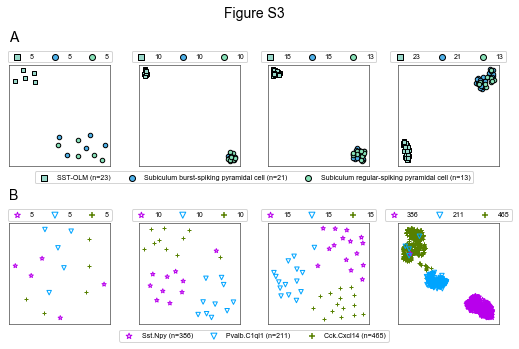

In [4]:
fig = generate_figures.generate_figure_S03()

celltypes = ['SST-OLM',
             'Subiculum burst-spiking pyramidal cell',
             'Subiculum regular-spiking pyramidal cell'
            ]
plot_row(fig, 0, [df, df_olm], df_mark, celltypes)

celltypes = ['Sst.Npy', 'Pvalb.C1ql1', 'Cck.Cxcl14']
plot_row(fig, 1, [df_harris], df_mark, celltypes)

fig.savefig('Figures/Figure S3.pdf')
plt.show()

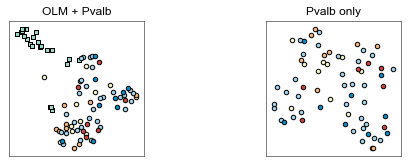

In [5]:
fig = plt.figure(figsize=(8.5,11))
ax = fig.add_axes([.29, .7, .22, .17])
ax.set_title('OLM + Pvalb')
df_data = pd.concat((df_old, df_olm), axis=0)
embedding_plot(df_data, ax, df_mark, to_trim=False)

ax = fig.add_axes([.71, .7, .22, .17])
ax.set_title('Pvalb only')
embedding_plot(df_old, ax, df_mark, to_trim=False)
fig.savefig('Plots/All Genes UMAP.pdf')
plt.show()